In [1]:
#import necessary packages
from pathlib import Path
import os
import ast
import shutil
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, fbeta_score, f1_score
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sktime.transformations.panel.rocket import (
    MiniRocket,
    MiniRocketMultivariate,
    MiniRocketMultivariateVariable,
)

In [2]:
#collection of dataset information for each telemetry data 
training_dfs = []
test_dfs = []

training_df = []
test_df = []

file_names = []

label_df = pd.read_csv("labeled_anomalies.csv")

train_data_path = "npy_train" 
test_data_path = "npy_test" 

os.makedirs("raw_train", exist_ok=True)
os.makedirs("raw_test", exist_ok=True)

index = 0
for root, _, files in os.walk(train_data_path):
    for file in files:
        example_path = os.path.join(root, file)
        filename = Path(example_path).stem
        
        row_indices = label_df[label_df['chan_id'] == filename].index.tolist()
        if not row_indices:
            continue
        spacecraft = label_df.loc[row_indices[0], 'spacecraft']
        
        if (spacecraft == "SMAP"): 
            data = np.load(example_path)
            df = pd.DataFrame(data)
            print("(train) df: ", filename, df.shape, "index: ", index)
            df.to_csv(f"raw_train/{filename}.csv", index=False)
            training_dfs.append(df) 
            index += 1

index = 0
for root, _, files in os.walk(test_data_path):
    for file in files:
        example_path = os.path.join(root, file)
        filename = Path(example_path).stem
        
        row_indices = label_df[label_df['chan_id'] == filename].index.tolist()
        if not row_indices:
            continue
        spacecraft = label_df.loc[row_indices[0], 'spacecraft']
        
        if (spacecraft == "SMAP"): 
            data = np.load(example_path)
            df = pd.DataFrame(data)
            print("(test) df: ", filename, df.shape, "index: ", index)
            test_dfs.append(df) 
            file_names.append(filename)
            
            index += 1

In [3]:
def get_data():
    training_dfs = {}
    test_dfs = {}
    file_names = {"train": {}, "test": {}}
    label_df = pd.read_csv("labeled_anomalies.csv")
    train_data_path = "raw_train" 
    test_data_path = "raw_test" 
    
    for root, _, files in os.walk(train_data_path):
        for file in files:
            example_path = os.path.join(root, file)
            filename = Path(example_path).stem
            df = pd.read_csv(example_path)
            channel = filename[0]            
            if (training_dfs.get(channel) == None):
                training_dfs[channel] = []
                file_names["train"][channel] = []
                training_dfs[channel].append(df)
                file_names["train"][channel].append(filename)
            else:
                training_dfs[channel].append(df)
                file_names["train"][channel].append(filename)
    
    for root, _, files in os.walk(test_data_path):
        for file in files:
            example_path = os.path.join(root, file)
            filename = Path(example_path).stem
            df = pd.read_csv(example_path)
            channel = filename[0]
            if (test_dfs.get(channel) == None):
                test_dfs[channel] = []
                file_names["test"][channel] = []
                test_dfs[channel].append(df)
                file_names["test"][channel].append(filename)
            else:
                test_dfs[channel].append(df)
                file_names["test"][channel].append(filename)

    return (training_dfs, test_dfs, label_df, file_names)

In [4]:
def create_windows(training_dfs, test_dfs, window_size, window_overlap, label_df, file_names):
    training_data = {}
    test_data = {}
    label_data = {}
    
    for channel in training_dfs.keys():
        training_data[channel] = []
        for df in training_dfs[channel]: 
            for i in range(0, len(df), window_overlap):
                window = []
                if i + window_size > len(df): 
                    window = df.iloc[-window_size:].to_numpy().tolist()
                else: 
                    window = df.iloc[i:i + window_size].to_numpy().tolist()
                np_window = np.array(window)
                transposed_window = np_window.T
                normal_window = transposed_window.tolist() 
                training_data[channel].append(normal_window)
                
    for channel in test_dfs.keys():
        test_data[channel] = []
        label_data[channel] = []
        for i in range(len(test_dfs[channel])):
            df = test_dfs[channel][i]
            for j in range(0, len(df), window_overlap):
                window = []
                if j + window_size > len(df): 
                    window = df.iloc[-window_size:].to_numpy().tolist()
                else: 
                    window = df.iloc[j:j + window_size].to_numpy().tolist()
                row_indices = label_df[label_df["chan_id"] == file_names["test"][channel][i]].index.tolist()
                
                if not row_indices:
                    continue

                anomaly_sequence = label_df.loc[row_indices[0], 'anomaly_sequences']
                anomaly_sequence = ast.literal_eval(anomaly_sequence)
                labeled = False
                for anomalies in anomaly_sequence:
                    if (not(anomalies[1] <= j or anomalies[0] >= j + window_size)) and labeled == False:
                        label_data[channel].append(1)
                        labeled = True
                if labeled == False:
                    label_data[channel].append(0)
                np_window = np.array(window)
                transposed_window = np_window.T
                normal_window = transposed_window.tolist() 
                test_data[channel].append(normal_window)
                
    return (training_data, test_data, label_data)

In [5]:
window_size = 60 
window_overlap = 20
training_dfs, test_dfs, label_df, file_names = get_data()

X_train_collection, X_test_collection, y_test_collection = create_windows(training_dfs, test_dfs, window_size, window_overlap, label_df, file_names)

data = {}
os.makedirs("data", exist_ok=True)

for channel in X_train_collection:
    if data.get(channel) is None:
        data[channel] = {}
    if data.get(channel).get("train") is None:
        X_train = np.array(X_train_collection[channel])
        path = f"data/{channel}/train"
        os.makedirs(path, exist_ok=True)
        np.save(path + f"/{channel}.npy", X_train)
        data[channel]["train"] = path + f"/{channel}.npy"
        print("train: ", channel, "shape: ", X_train.shape)
    else:
        print("Error: duplicate training data sets")
   
    
for channel in X_test_collection: 
    if data.get(channel) is None:
        continue
    if data.get(channel).get("test") is None:
        X_test = np.array(X_test_collection[channel])
        path = f"data/{channel}/test"
        os.makedirs(path, exist_ok=True)
        np.save(path + f"/{channel}.npy", X_test)
        data[channel]["test"] = path + f"/{channel}.npy"
        print("test: ", channel, "shape: ", X_test.shape)
    else:
        print("Error: duplicate testing data sets")
   
  
for channel in y_test_collection:
    if data.get(channel) is None:
        continue
    if data.get(channel).get("label") is None:
        y_test = np.array(y_test_collection[channel])
        path = f"data/{channel}/label"
        os.makedirs(path, exist_ok=True)
        np.save(path + f"/{channel}.npy", y_test)
        data[channel]["label"] = path + f"/{channel}.npy"
        print("label: ", channel, "shape: ", y_test.shape)
    else:
        print("Error: duplicate label data sets")
    

train:  D shape:  (1445, 25, 60)
train:  S shape:  (141, 25, 60)
train:  P shape:  (703, 25, 60)
train:  T shape:  (431, 25, 60)
train:  E shape:  (1867, 25, 60)
train:  A shape:  (842, 25, 60)
train:  R shape:  (144, 25, 60)
train:  G shape:  (793, 25, 60)
train:  F shape:  (432, 25, 60)
train:  B shape:  (122, 25, 60)
test:  D shape:  (4789, 25, 60)
test:  S shape:  (367, 25, 60)
test:  P shape:  (2056, 25, 60)
test:  T shape:  (1292, 25, 60)
test:  E shape:  (5486, 25, 60)
test:  A shape:  (3374, 25, 60)
test:  R shape:  (363, 25, 60)
test:  G shape:  (2405, 25, 60)
test:  F shape:  (1281, 25, 60)
test:  B shape:  (403, 25, 60)
label:  D shape:  (4789,)
label:  S shape:  (367,)
label:  P shape:  (2056,)
label:  T shape:  (1292,)
label:  E shape:  (5486,)
label:  A shape:  (3374,)
label:  R shape:  (363,)
label:  G shape:  (2405,)
label:  F shape:  (1281,)
label:  B shape:  (403,)


In [6]:
channel_names = []

for channel in os.listdir("data"):
    if os.path.isdir(os.path.join("data", channel)):
        channel_names.append(channel)
print(channel_names)

['R', 'G', 'T', 'S', 'A', 'F', 'D', 'E', 'B', 'P']


In [7]:
raw_data= {}
for channel in channel_names:
    raw_data[channel] = {}
    training_data_path = f"data/{channel}/train/{channel}.npy"
    testing_data_path = f"data/{channel}/test/{channel}.npy"
    label_data_path = f"data/{channel}/label/{channel}.npy"
    
    X_train = np.load(training_data_path)
    X_test = np.load(testing_data_path)
    y_test = np.load(label_data_path)

    raw_data[channel]["train"] = X_train
    print("train: ", channel, "shape: ", X_train.shape)
    raw_data[channel]["test"] = X_test
    print("test: ", channel, "shape: ", X_test.shape)
    raw_data[channel]["label"] = y_test
    print("label: ", channel, "shape: ", y_test.shape)

train:  R shape:  (144, 25, 60)
test:  R shape:  (363, 25, 60)
label:  R shape:  (363,)
train:  G shape:  (793, 25, 60)
test:  G shape:  (2405, 25, 60)
label:  G shape:  (2405,)
train:  T shape:  (431, 25, 60)
test:  T shape:  (1292, 25, 60)
label:  T shape:  (1292,)
train:  S shape:  (141, 25, 60)
test:  S shape:  (367, 25, 60)
label:  S shape:  (367,)
train:  A shape:  (842, 25, 60)
test:  A shape:  (3374, 25, 60)
label:  A shape:  (3374,)
train:  F shape:  (432, 25, 60)
test:  F shape:  (1281, 25, 60)
label:  F shape:  (1281,)
train:  D shape:  (1445, 25, 60)
test:  D shape:  (4789, 25, 60)
label:  D shape:  (4789,)
train:  E shape:  (1867, 25, 60)
test:  E shape:  (5486, 25, 60)
label:  E shape:  (5486,)
train:  B shape:  (122, 25, 60)
test:  B shape:  (403, 25, 60)
label:  B shape:  (403,)
train:  P shape:  (703, 25, 60)
test:  P shape:  (2056, 25, 60)
label:  P shape:  (2056,)


In [8]:
transformed_data= {}
os.makedirs("transformed_data", exist_ok=True)

for channel in channel_names:
    transformed_data[channel] = {}
    training_data_path = f"data/{channel}/train/{channel}.npy"
    testing_data_path = f"data/{channel}/test/{channel}.npy"
    label_data_path = f"data/{channel}/label/{channel}.npy"
    
    X_train = np.load(training_data_path)
    X_test = np.load(testing_data_path)
    y_test = np.load(label_data_path)

    minirocket = MiniRocketMultivariate(num_kernels=20000, n_jobs = 2, random_state = 42) 
    minirocket.fit(X_train)
    X_transform_train = minirocket.transform(X_train)
    X_transform_test = minirocket.transform(X_test)

    transformed_data[channel]["train"] = X_transform_train
    print("train: ", channel, "shape: ", X_transform_train.shape)
    transformed_data[channel]["test"] = X_transform_test
    print("test: ", channel, "shape: ", X_transform_test.shape)
    transformed_data[channel]["label"] = y_test
    print("label: ", channel, "shape: ", y_test.shape)

for channel in transformed_data: 
    print("store: ", channel)
    X_transform_train = transformed_data[channel]["train"]
    X_transform_test = transformed_data[channel]["test"]
    y_test = transformed_data[channel]["label"]

    train_df = pd.DataFrame(X_transform_train)
    test_df = pd.DataFrame(X_transform_test)
    label_df = pd.DataFrame(y_test)

    training_data_path = f"transformed_data/{channel}/train"
    testing_data_path = f"transformed_data/{channel}/test"
    label_data_path = f"transformed_data/{channel}/label"
    
    os.makedirs(training_data_path, exist_ok=True)
    os.makedirs(testing_data_path, exist_ok=True)
    os.makedirs(label_data_path, exist_ok=True)

    train_df.to_csv(training_data_path + f"/{channel}.csv", index=False)
    test_df.to_csv(testing_data_path + f"/{channel}.csv", index=False)
    label_df.to_csv(label_data_path + f"/{channel}.csv", index=False)  

train:  R shape:  (144, 19992)
test:  R shape:  (363, 19992)
label:  R shape:  (363,)
train:  G shape:  (793, 19992)
test:  G shape:  (2405, 19992)
label:  G shape:  (2405,)
train:  T shape:  (431, 19992)
test:  T shape:  (1292, 19992)
label:  T shape:  (1292,)
train:  S shape:  (141, 19992)
test:  S shape:  (367, 19992)
label:  S shape:  (367,)
train:  A shape:  (842, 19992)
test:  A shape:  (3374, 19992)
label:  A shape:  (3374,)
train:  F shape:  (432, 19992)
test:  F shape:  (1281, 19992)
label:  F shape:  (1281,)
train:  D shape:  (1445, 19992)
test:  D shape:  (4789, 19992)
label:  D shape:  (4789,)
train:  E shape:  (1867, 19992)
test:  E shape:  (5486, 19992)
label:  E shape:  (5486,)
train:  B shape:  (122, 19992)
test:  B shape:  (403, 19992)
label:  B shape:  (403,)
train:  P shape:  (703, 19992)
test:  P shape:  (2056, 19992)
label:  P shape:  (2056,)
store:  R
store:  G
store:  T
store:  S
store:  A
store:  F
store:  D
store:  E
store:  B
store:  P


In [9]:
min_max_fitted_data = {}

for channel in channel_names: 
    min_max_fitted_data[channel] = {}

    training_data_path = f"transformed_data/{channel}/train/{channel}.csv"
    testing_data_path = f"transformed_data/{channel}/test/{channel}.csv"
    label_data_path = f"transformed_data/{channel}/label/{channel}.csv"
    
    X_transform_train = pd.read_csv(training_data_path).to_numpy()
    X_transform_test =  pd.read_csv(testing_data_path).to_numpy()
    y_test = pd.read_csv(label_data_path).to_numpy()

    scaler = MinMaxScaler()
    scaler.fit(X_transform_train)
    X_fit_train = scaler.transform(X_transform_train)
    X_fit_test = scaler.transform(X_transform_test)
    
    min_max_fitted_data[channel]["train"] = X_fit_train
    min_max_fitted_data[channel]["test"] = X_fit_test
    min_max_fitted_data[channel]["label"] = y_test
    
    print("train: ", channel, "shape: ", X_fit_train.shape)
    print("test: ", channel, "shape: ", X_fit_test.shape)
    print("label: ", channel, "shape: ", y_test.shape)

train:  R shape:  (144, 19992)
test:  R shape:  (363, 19992)
label:  R shape:  (363, 1)
train:  G shape:  (793, 19992)
test:  G shape:  (2405, 19992)
label:  G shape:  (2405, 1)
train:  T shape:  (431, 19992)
test:  T shape:  (1292, 19992)
label:  T shape:  (1292, 1)
train:  S shape:  (141, 19992)
test:  S shape:  (367, 19992)
label:  S shape:  (367, 1)
train:  A shape:  (842, 19992)
test:  A shape:  (3374, 19992)
label:  A shape:  (3374, 1)
train:  F shape:  (432, 19992)
test:  F shape:  (1281, 19992)
label:  F shape:  (1281, 1)
train:  D shape:  (1445, 19992)
test:  D shape:  (4789, 19992)
label:  D shape:  (4789, 1)
train:  E shape:  (1867, 19992)
test:  E shape:  (5486, 19992)
label:  E shape:  (5486, 1)
train:  B shape:  (122, 19992)
test:  B shape:  (403, 19992)
label:  B shape:  (403, 1)
train:  P shape:  (703, 19992)
test:  P shape:  (2056, 19992)
label:  P shape:  (2056, 1)


In [10]:
standard_fitted_data = {}

for channel in channel_names: 
    standard_fitted_data[channel] = {}

    training_data_path = f"transformed_data/{channel}/train/{channel}.csv"
    testing_data_path = f"transformed_data/{channel}/test/{channel}.csv"
    label_data_path = f"transformed_data/{channel}/label/{channel}.csv"
    
    X_transform_train = pd.read_csv(training_data_path).to_numpy()
    X_transform_test =  pd.read_csv(testing_data_path).to_numpy()
    y_test = pd.read_csv(label_data_path).to_numpy()

    scaler = StandardScaler()
    scaler.fit(X_transform_train)
    X_fit_train = scaler.transform(X_transform_train)
    X_fit_test = scaler.transform(X_transform_test)
    
    standard_fitted_data[channel]["train"] = X_fit_train
    standard_fitted_data[channel]["test"] = X_fit_test
    standard_fitted_data[channel]["label"] = y_test
    
    print("train: ", channel, "shape: ", X_fit_train.shape)
    print("test: ", channel, "shape: ", X_fit_test.shape)
    print("label: ", channel, "shape: ", y_test.shape)

train:  R shape:  (144, 19992)
test:  R shape:  (363, 19992)
label:  R shape:  (363, 1)
train:  G shape:  (793, 19992)
test:  G shape:  (2405, 19992)
label:  G shape:  (2405, 1)
train:  T shape:  (431, 19992)
test:  T shape:  (1292, 19992)
label:  T shape:  (1292, 1)
train:  S shape:  (141, 19992)
test:  S shape:  (367, 19992)
label:  S shape:  (367, 1)
train:  A shape:  (842, 19992)
test:  A shape:  (3374, 19992)
label:  A shape:  (3374, 1)
train:  F shape:  (432, 19992)
test:  F shape:  (1281, 19992)
label:  F shape:  (1281, 1)
train:  D shape:  (1445, 19992)
test:  D shape:  (4789, 19992)
label:  D shape:  (4789, 1)
train:  E shape:  (1867, 19992)
test:  E shape:  (5486, 19992)
label:  E shape:  (5486, 1)
train:  B shape:  (122, 19992)
test:  B shape:  (403, 19992)
label:  B shape:  (403, 1)
train:  P shape:  (703, 19992)
test:  P shape:  (2056, 19992)
label:  P shape:  (2056, 1)


In [11]:
# performance bad for channels B, R, and S due to their small training data size
# nu - controls boundary tightness (Smaller nu → tighter boundary → fewer false positives, Larger nu → looser boundary → higher recall)
# threshold	- converts scores (anomaly / normal)

# Large (1000+ windows/channel)	Mostly clean	0.01 – 0.02
# Medium (hundreds of windows)	Mostly clean	0.02 – 0.05
# Small or noisy	Some anomalies in training	0.05 – 0.1
#tighter nu makes more sense as the training data is supposed to have only normal data - needs confirmation at this point in time 

anomaly_rate = []
for channel in standard_fitted_data: 
    print("channel: ", channel)
    anomaly_count = 0
    for label in standard_fitted_data[channel]["label"]:
        if label == 1:
            anomaly_count += 1
    anomaly_rate.append(anomaly_count / len(standard_fitted_data[channel]["label"]))
    print("anomaly_rate: ", anomaly_count / len(standard_fitted_data[channel]["label"]))

print(anomaly_rate)


channel:  R
anomaly_rate:  0.01928374655647383
channel:  G
anomaly_rate:  0.021205821205821207
channel:  T
anomaly_rate:  0.14628482972136223
channel:  S
anomaly_rate:  0.0681198910081744
channel:  A
anomaly_rate:  0.16478956727919383
channel:  F
anomaly_rate:  0.12724434035909446
channel:  D
anomaly_rate:  0.22635205679682607
channel:  E
anomaly_rate:  0.11009843237331389
channel:  B
anomaly_rate:  0.01488833746898263
channel:  P
anomaly_rate:  0.14348249027237353
[0.01928374655647383, 0.021205821205821207, 0.14628482972136223, 0.0681198910081744, 0.16478956727919383, 0.12724434035909446, 0.22635205679682607, 0.11009843237331389, 0.01488833746898263, 0.14348249027237353]


In [12]:
def predict(threshold, decision_scores):
    y_pred = []
    for score in decision_scores: 
        if score < threshold: 
            y_pred.append(1)
        else:
            y_pred.append(0)
    return np.array(y_pred)

In [13]:
def one_class_svm(channel_data, channel):
    print("channel:", channel)
    clf = OneClassSVM().fit(channel_data["train"])
    decision_scores = clf.decision_function(channel_data["test"])
    
    percentiles = np.arange(1, 30 + 1)
    thresholds = []
    for percent in percentiles: 
        thresholds.append(np.percentile(decision_scores, percent))
    
    # best_f1_score = 0
    best_scores = (0, 0, 0)  

    for th in thresholds:
        y_pred = predict(th, decision_scores)
        # f1 = f1_score(channel_data["label"], y_pred)
        recall = recall_score(channel_data["label"], y_pred, pos_label=1)
        precision = precision_score(channel_data["label"], y_pred, zero_division=0)
        if (recall > best_scores[0]) or (recall == best_scores[0] and precision > best_scores[1]):
            best_scores = (recall, precision, th)

    best_threshold = best_scores[2]
    
    y_test = channel_data["label"]
    y_pred = predict(best_threshold, decision_scores)
    print("best_threshold: ", best_threshold)
    print(classification_report(y_test, y_pred))
    precision = precision_score(y_test, y_pred, average='weighted')
    print("FDR:", 1 - precision)
    c_m = confusion_matrix(y_test, y_pred)
    print(c_m)

In [14]:
for channel in standard_fitted_data:
    one_class_svm(standard_fitted_data[channel], channel)

channel: R
best_threshold:  -48.727158729283914
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       356
           1       0.12      0.43      0.19         7

    accuracy                           0.93       363
   macro avg       0.55      0.68      0.58       363
weighted avg       0.97      0.93      0.95       363

FDR: 0.028575806477904475
[[334  22]
 [  4   3]]
channel: G
best_threshold:  -2.8310871356132257
              precision    recall  f1-score   support

           0       0.99      0.71      0.82      2354
           1       0.04      0.63      0.08        51

    accuracy                           0.71      2405
   macro avg       0.52      0.67      0.45      2405
weighted avg       0.97      0.71      0.81      2405

FDR: 0.03131591500501396
[[1664  690]
 [  19   32]]
channel: T
best_threshold:  -0.6993640737642408
              precision    recall  f1-score   support

           0       0.84      0.69      0.75   

In [15]:
def isolation_forest(channel_data, channel):
    print("channel:", channel)
    clf = IsolationForest(random_state=42, n_jobs=-1).fit(channel_data["train"])
    decision_scores = clf.decision_function(channel_data["test"])
    
    percentiles = np.arange(1, 30 + 1)
    thresholds = []
    for percent in percentiles: 
        thresholds.append(np.percentile(decision_scores, percent))
    
    # best_f1_score = 0
    best_scores = (0, 0, 0)  

    for th in thresholds:
        y_pred = predict(th, decision_scores)
        # f1 = f1_score(channel_data["label"], y_pred)
        recall = recall_score(channel_data["label"], y_pred, pos_label=1)
        precision = precision_score(channel_data["label"], y_pred, zero_division=0)
        if (recall > best_scores[0]) or (recall == best_scores[0] and precision > best_scores[1]):
            best_scores = (recall, precision, th)

    best_threshold = best_scores[2]
    
    y_test = channel_data["label"]
    y_pred = predict(best_threshold, decision_scores)
    print("best_threshold: ", best_threshold)
    print(classification_report(y_test, y_pred))
    precision = precision_score(y_test, y_pred, average='weighted')
    print("FDR:", 1 - precision)
    c_m = confusion_matrix(y_test, y_pred)
    print(c_m)

In [16]:
for channel in standard_fitted_data:
    isolation_forest(standard_fitted_data[channel], channel)

channel: R
best_threshold:  0.09339214078190028
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       356
           1       0.12      0.43      0.19         7

    accuracy                           0.93       363
   macro avg       0.55      0.68      0.58       363
weighted avg       0.97      0.93      0.95       363

FDR: 0.028575806477904475
[[334  22]
 [  4   3]]
channel: G
best_threshold:  0.023541406314472532
              precision    recall  f1-score   support

           0       0.98      0.74      0.84      2354
           1       0.02      0.20      0.03        51

    accuracy                           0.73      2405
   macro avg       0.50      0.47      0.44      2405
weighted avg       0.96      0.73      0.82      2405

FDR: 0.04342500223842205
[[1738  616]
 [  41   10]]
channel: T
best_threshold:  0.11286696605197702
              precision    recall  f1-score   support

           0       0.88      0.72      0.79  

In [17]:
#LOF learns a reference density from X_train, new points are compared against training density
def local_outlier_factor(channel_data, channel):
    print("channel:", channel)
    clf = LocalOutlierFactor(n_neighbors=50, novelty=True)
    clf.fit(channel_data["train"])
    decision_scores = clf.decision_function(channel_data["test"])
 
    percentiles = np.arange(1, 30 + 1)
    thresholds = []
    for percent in percentiles: 
        thresholds.append(np.percentile(decision_scores, percent))
    
    # best_f1_score = 0
    best_scores = (0, 0, 0)  

    for th in thresholds:
        y_pred = predict(th, decision_scores)
        # f1 = f1_score(channel_data["label"], y_pred)
        recall = recall_score(channel_data["label"], y_pred, pos_label=1)
        precision = precision_score(channel_data["label"], y_pred, zero_division=0)
        if (recall > best_scores[0]) or (recall == best_scores[0] and precision > best_scores[1]):
            best_scores = (recall, precision, th)

    best_threshold = best_scores[2]
    
    y_test = channel_data["label"]
    y_pred = predict(best_threshold, decision_scores)
    print("best_threshold: ", best_threshold)
    print(classification_report(y_test, y_pred))
    precision = precision_score(y_test, y_pred, average='weighted')
    print("FDR:", 1 - precision)
    c_m = confusion_matrix(y_test, y_pred)
    print(c_m)

In [18]:
for channel in standard_fitted_data:
    local_outlier_factor(standard_fitted_data[channel], channel)

channel: R
best_threshold:  -173082860.74334168
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       356
           1       0.27      0.43      0.33         7

    accuracy                           0.97       363
   macro avg       0.63      0.70      0.66       363
weighted avg       0.97      0.97      0.97       363

FDR: 0.025169045830202852
[[348   8]
 [  4   3]]
channel: G
best_threshold:  -0.2639916256647743
              precision    recall  f1-score   support

           0       0.99      0.76      0.86      2354
           1       0.05      0.59      0.09        51

    accuracy                           0.75      2405
   macro avg       0.52      0.67      0.47      2405
weighted avg       0.97      0.75      0.84      2405

FDR: 0.0315412398972319
[[1783  571]
 [  21   30]]
channel: T
best_threshold:  0.48805117001577236
              precision    recall  f1-score   support

           0       0.85      0.70      0.77    

In [19]:
#LOF learns a reference density from X_train, new points are compared against training density
def ensemble_local_outlier_factor(channel_data, channel):
    clf = LocalOutlierFactor(n_neighbors=50, novelty=True)
    clf.fit(channel_data["train"])
    decision_scores = clf.decision_function(channel_data["test"])
 
    percentiles = np.arange(1, 30 + 1)
    thresholds = []
    for percent in percentiles: 
        thresholds.append(np.percentile(decision_scores, percent))
    
    # best_f1_score = 0
    best_scores = (0, 0, 0)  

    for th in thresholds:
        y_pred = predict(th, decision_scores)
        # f1 = f1_score(channel_data["label"], y_pred)
        recall = recall_score(channel_data["label"], y_pred, pos_label=1)
        precision = precision_score(channel_data["label"], y_pred, zero_division=0)
        if (recall > best_scores[0]) or (recall == best_scores[0] and precision > best_scores[1]):
            best_scores = (recall, precision, th)

    best_threshold = best_scores[2]
    
    return predict(best_threshold, decision_scores)

In [20]:
def ensemble_isolation_forest(channel_data, channel):
    clf = IsolationForest(random_state=42, n_jobs=-1).fit(channel_data["train"])
    decision_scores = clf.decision_function(channel_data["test"])
    
    percentiles = np.arange(1, 30 + 1)
    thresholds = []
    for percent in percentiles: 
        thresholds.append(np.percentile(decision_scores, percent))
    
    # best_f1_score = 0
    best_scores = (0, 0, 0)  

    for th in thresholds:
        y_pred = predict(th, decision_scores)
        # f1 = f1_score(channel_data["label"], y_pred)
        recall = recall_score(channel_data["label"], y_pred, pos_label=1)
        precision = precision_score(channel_data["label"], y_pred, zero_division=0)
        if (recall > best_scores[0]) or (recall == best_scores[0] and precision > best_scores[1]):
            best_scores = (recall, precision, th)

    best_threshold = best_scores[2]
    
    return predict(best_threshold, decision_scores)
    

In [21]:
def ensemble_one_class_svm(channel_data, channel):
    clf = OneClassSVM().fit(channel_data["train"])
    decision_scores = clf.decision_function(channel_data["test"])
   
    percentiles = np.arange(1, 30 + 1)
    thresholds = []
    for percent in percentiles: 
        thresholds.append(np.percentile(decision_scores, percent))
    
    # best_f1_score = 0
    best_scores = (0, 0, 0)  

    for th in thresholds:
        y_pred = predict(th, decision_scores)
        # f1 = f1_score(channel_data["label"], y_pred)
        recall = recall_score(channel_data["label"], y_pred, pos_label=1)
        precision = precision_score(channel_data["label"], y_pred, zero_division=0)
        if (recall > best_scores[0]) or (recall == best_scores[0] and precision > best_scores[1]):
            best_scores = (recall, precision, th)

    best_threshold = best_scores[2]
    
    return predict(best_threshold, decision_scores)

In [30]:
# Store results for summary
ensemble_results = {}

for channel in standard_fitted_data: 
    y_pred_one_class_svm = ensemble_one_class_svm(standard_fitted_data[channel], channel)
    y_pred_isolation_forest = ensemble_isolation_forest(standard_fitted_data[channel], channel)
    y_pred_local_outlier_factor = ensemble_local_outlier_factor(standard_fitted_data[channel], channel)

    y_pred = []
    for i in range(len(y_pred_one_class_svm)): 
        ensemble = y_pred_one_class_svm[i] + y_pred_isolation_forest[i] + y_pred_local_outlier_factor[i]
        if ensemble >= 1: 
            y_pred.append(1)
        else:
            y_pred.append(0)
    
    print("channel: ",channel)
    y_test = (standard_fitted_data[channel]["label"])
    print(classification_report(y_test, y_pred))
    
    # Calculate and store metrics
    precision_1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall_1 = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1_1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    fdr = 1 - precision_1
    
    print("FDR:", fdr)
    c_m = confusion_matrix(y_test, y_pred)
    print(c_m)
    
    # Store results
    ensemble_results[channel] = {
        'precision': precision_1,
        'recall': recall_1,
        'f1_score': f1_1,
        'fdr': fdr,
        'confusion_matrix': c_m
    }

channel:  R
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       356
           1       0.12      0.43      0.19         7

    accuracy                           0.93       363
   macro avg       0.55      0.68      0.58       363
weighted avg       0.97      0.93      0.95       363

FDR: 0.88
[[334  22]
 [  4   3]]
channel:  G
              precision    recall  f1-score   support

           0       0.99      0.50      0.66      2354
           1       0.03      0.78      0.06        51

    accuracy                           0.50      2405
   macro avg       0.51      0.64      0.36      2405
weighted avg       0.97      0.50      0.65      2405

FDR: 0.967266775777414
[[1172 1182]
 [  11   40]]
channel:  T
              precision    recall  f1-score   support

           0       0.87      0.34      0.49      1103
           1       0.15      0.69      0.25       189

    accuracy                           0.39      1292
   macro 

## Performance Summary

This section provides an overview of the ensemble model's performance across all channels.

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [32]:
summary_data = []
for channel, metrics in ensemble_results.items():
    summary_data.append({
        'Channel': channel,
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1 Score': metrics['f1_score'],
        'FDR': metrics['fdr']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Channel')

print("Ensemble Model Performance Summary by Channel\n")
print(summary_df.to_string(index=False))

print("\n\nAggregate Statistics Across All Channels\n")
print(f"Average Precision: {summary_df['Precision'].mean():.4f}")
print(f"Average Recall: {summary_df['Recall'].mean():.4f}")
print(f"Average F1 Score: {summary_df['F1 Score'].mean():.4f}")
print(f"Average FDR: {summary_df['FDR'].mean():.4f}")

Ensemble Model Performance Summary by Channel

Channel  Precision   Recall  F1 Score      FDR
      A   0.051496 0.133094  0.074260 0.948504
      B   0.103448 0.500000  0.171429 0.896552
      D   0.287879 0.613469  0.391868 0.712121
      E   0.125095 0.544702  0.203463 0.874905
      F   0.136802 0.435583  0.208211 0.863198
      G   0.032733 0.784314  0.062844 0.967267
      P   0.197941 0.586441  0.295979 0.802059
      R   0.120000 0.428571  0.187500 0.880000
      S   0.130719 0.800000  0.224719 0.869281
      T   0.152149 0.693122  0.249524 0.847851


Aggregate Statistics Across All Channels

Average Precision: 0.1338
Average Recall: 0.5519
Average F1 Score: 0.2070
Average FDR: 0.8662


### Performance Metrics Visualisation

Visual comparison of key performance metrics across all channels.

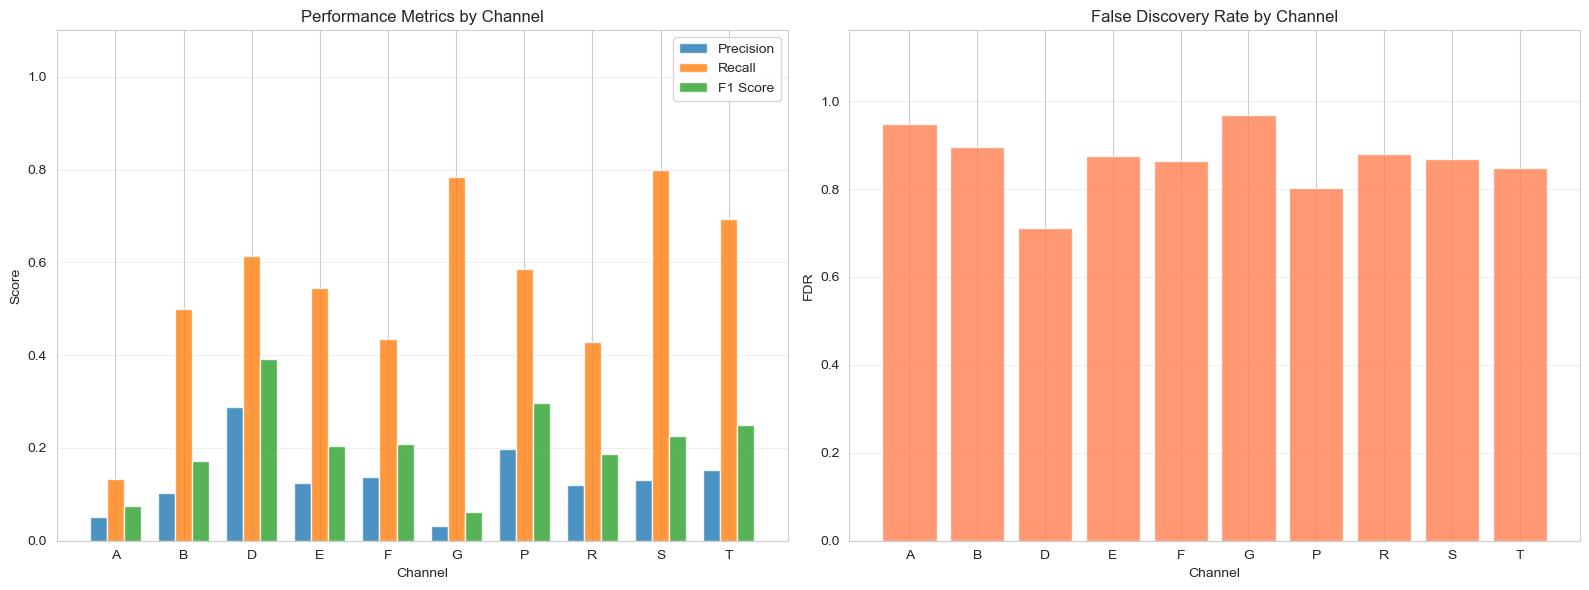

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Precision, Recall, F1 Score
x = np.arange(len(summary_df))
width = 0.25

axes[0].bar(x - width, summary_df['Precision'], width, label='Precision', alpha=0.8)
axes[0].bar(x, summary_df['Recall'], width, label='Recall', alpha=0.8)
axes[0].bar(x + width, summary_df['F1 Score'], width, label='F1 Score', alpha=0.8)

axes[0].set_xlabel('Channel')
axes[0].set_ylabel('Score')
axes[0].set_title('Performance Metrics by Channel')
axes[0].set_xticks(x)
axes[0].set_xticklabels(summary_df['Channel'])
axes[0].legend()
axes[0].set_ylim(0, 1.1)
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: False Discovery Rate
axes[1].bar(summary_df['Channel'], summary_df['FDR'], color='coral', alpha=0.8)
axes[1].set_xlabel('Channel')
axes[1].set_ylabel('FDR')
axes[1].set_title('False Discovery Rate by Channel')
axes[1].set_ylim(0, max(summary_df['FDR']) * 1.2)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('paper/template/figs/performance_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

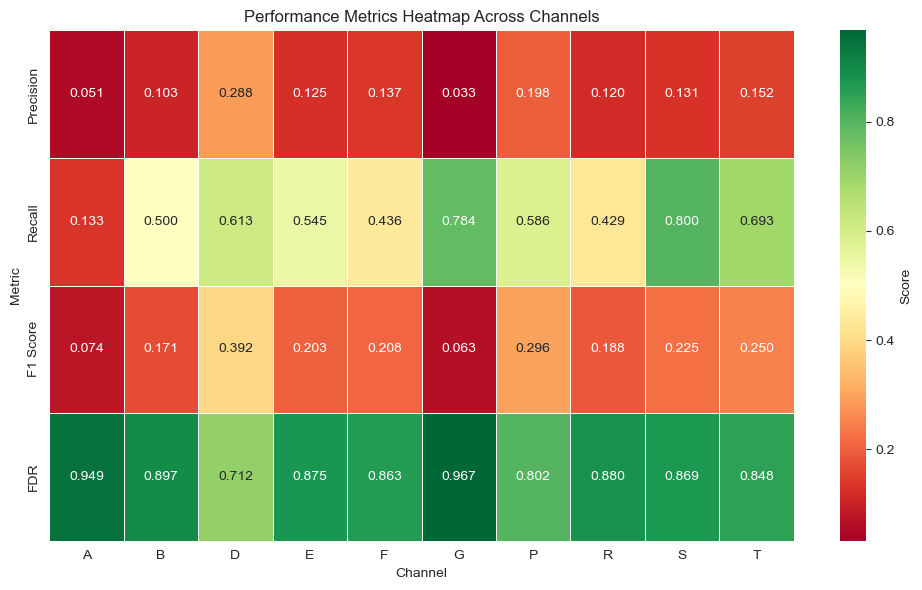

In [47]:
# Heatmap of performance metrics
plt.figure(figsize=(10, 6))
metrics_for_heatmap = summary_df.set_index('Channel')[['Precision', 'Recall', 'F1 Score', 'FDR']]
sns.heatmap(metrics_for_heatmap.T, annot=True, fmt='.3f', cmap='RdYlGn', center=0.5, 
            cbar_kws={'label': 'Score'}, linewidths=0.5)
plt.title('Performance Metrics Heatmap Across Channels')
plt.ylabel('Metric')
plt.xlabel('Channel')
plt.tight_layout()
plt.savefig('paper/template/figs/performance_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### Confusion Matrices

Detailed confusion matrices for each channel showing true positives, false positives, true negatives, and false negatives.

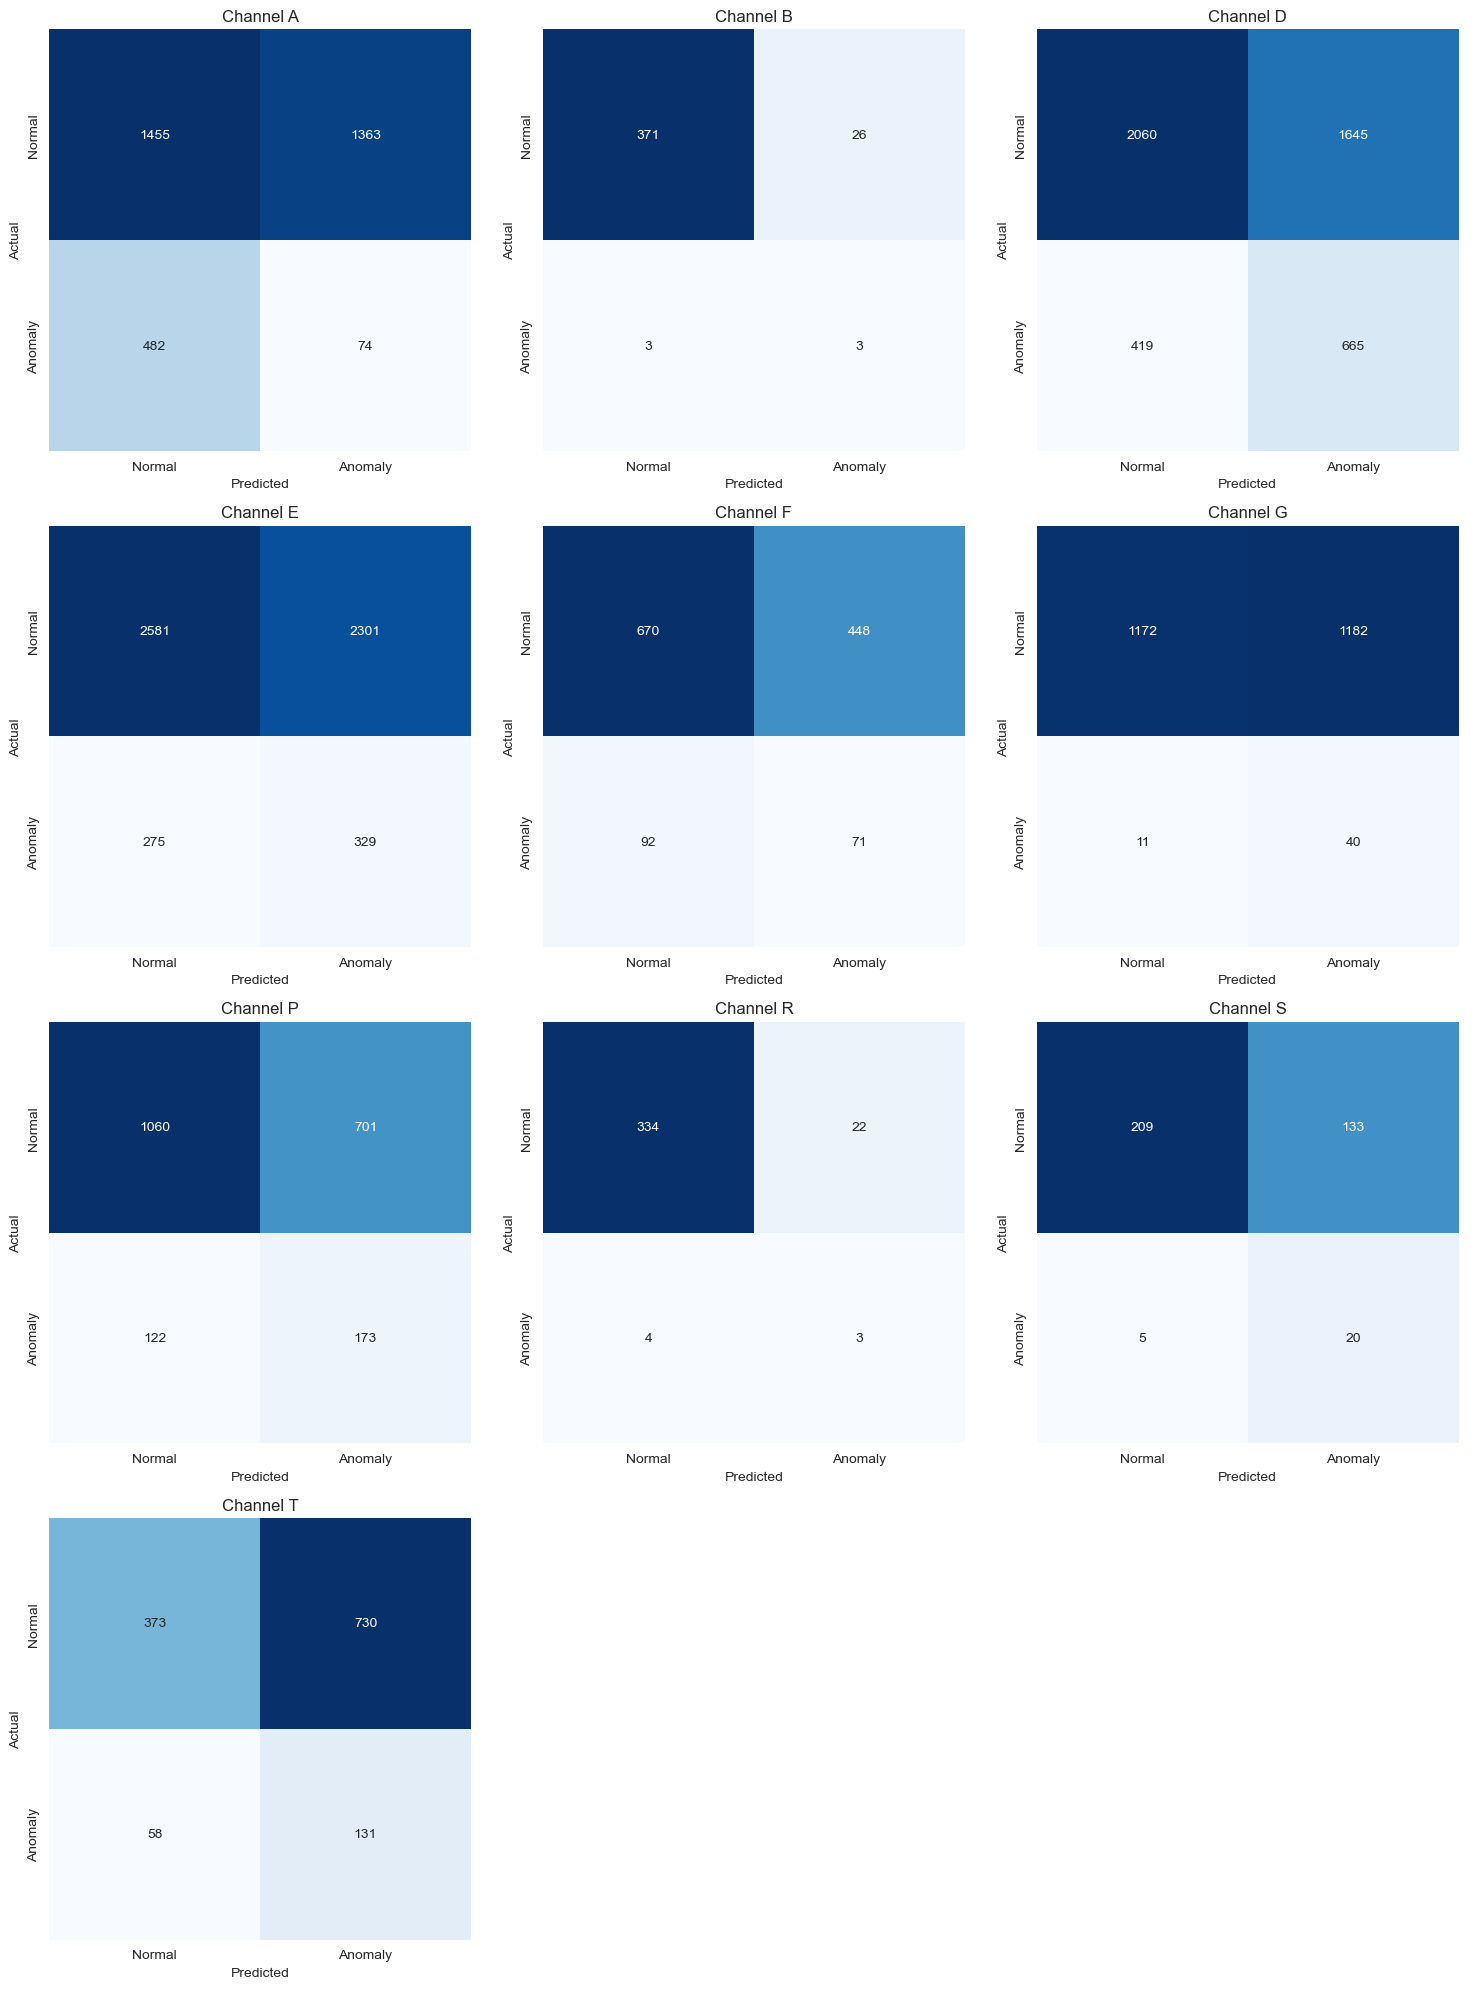

In [48]:
n_channels = len(ensemble_results)
n_cols = 3
n_rows = (n_channels + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_channels > 1 else [axes]

for idx, (channel, metrics) in enumerate(sorted(ensemble_results.items())):
    cm = metrics['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                cbar=False, square=True)
    axes[idx].set_title(f'Channel {channel}')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_xticklabels(['Normal', 'Anomaly'])
    axes[idx].set_yticklabels(['Normal', 'Anomaly'])
for idx in range(n_channels, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('paper/template/figs/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

### Overall Analysis

Summary of key findings from the ensemble anomaly detection model.

In [49]:
print("Overall Performance Analysis:\n")

best_precision_channel = summary_df.loc[summary_df['Precision'].idxmax()]
best_recall_channel = summary_df.loc[summary_df['Recall'].idxmax()]
best_f1_channel = summary_df.loc[summary_df['F1 Score'].idxmax()]

print(f"Channel with highest precision: {best_precision_channel['Channel']} ({best_precision_channel['Precision']:.4f})")
print(f"Channel with highest recall: {best_recall_channel['Channel']} ({best_recall_channel['Recall']:.4f})")
print(f"Channel with highest F1 score: {best_f1_channel['Channel']} ({best_f1_channel['F1 Score']:.4f})")

print(f"\nChannels with F1 score above 0.5: {len(summary_df[summary_df['F1 Score'] > 0.5])}/{len(summary_df)}")
print(f"Channels with recall above 0.7: {len(summary_df[summary_df['Recall'] > 0.7])}/{len(summary_df)}")
print(f"Channels with precision above 0.5: {len(summary_df[summary_df['Precision'] > 0.5])}/{len(summary_df)}")

Overall Performance Analysis:

Channel with highest precision: D (0.2879)
Channel with highest recall: S (0.8000)
Channel with highest F1 score: D (0.3919)

Channels with F1 score above 0.5: 0/10
Channels with recall above 0.7: 2/10
Channels with precision above 0.5: 0/10


### Individual Model Comparison

Detailed comparison of individual model performance across all channels.

In [50]:
svm_results = {}
if_results = {}
lof_results = {}

for channel in standard_fitted_data:
    # 1-Class SVM
    clf_svm = OneClassSVM().fit(standard_fitted_data[channel]["train"])
    scores_svm = clf_svm.decision_function(standard_fitted_data[channel]["test"])
    percentiles = np.arange(1, 30 + 1)
    thresholds = [np.percentile(scores_svm, p) for p in percentiles]
    best_scores_svm = (0, 0, 0)
    for th in thresholds:
        y_pred = predict(th, scores_svm)
        recall = recall_score(standard_fitted_data[channel]["label"], y_pred, pos_label=1)
        precision = precision_score(standard_fitted_data[channel]["label"], y_pred, zero_division=0)
        if (recall > best_scores_svm[0]) or (recall == best_scores_svm[0] and precision > best_scores_svm[1]):
            best_scores_svm = (recall, precision, th)
    y_pred_svm = predict(best_scores_svm[2], scores_svm)
    
    # Isolation Forest
    clf_if = IsolationForest(random_state=42, n_jobs=-1).fit(standard_fitted_data[channel]["train"])
    scores_if = clf_if.decision_function(standard_fitted_data[channel]["test"])
    thresholds = [np.percentile(scores_if, p) for p in percentiles]
    best_scores_if = (0, 0, 0)
    for th in thresholds:
        y_pred = predict(th, scores_if)
        recall = recall_score(standard_fitted_data[channel]["label"], y_pred, pos_label=1)
        precision = precision_score(standard_fitted_data[channel]["label"], y_pred, zero_division=0)
        if (recall > best_scores_if[0]) or (recall == best_scores_if[0] and precision > best_scores_if[1]):
            best_scores_if = (recall, precision, th)
    y_pred_if = predict(best_scores_if[2], scores_if)
    
    # Local Outlier Factor
    clf_lof = LocalOutlierFactor(n_neighbors=50, novelty=True)
    clf_lof.fit(standard_fitted_data[channel]["train"])
    scores_lof = clf_lof.decision_function(standard_fitted_data[channel]["test"])
    thresholds = [np.percentile(scores_lof, p) for p in percentiles]
    best_scores_lof = (0, 0, 0)
    for th in thresholds:
        y_pred = predict(th, scores_lof)
        recall = recall_score(standard_fitted_data[channel]["label"], y_pred, pos_label=1)
        precision = precision_score(standard_fitted_data[channel]["label"], y_pred, zero_division=0)
        if (recall > best_scores_lof[0]) or (recall == best_scores_lof[0] and precision > best_scores_lof[1]):
            best_scores_lof = (recall, precision, th)
    y_pred_lof = predict(best_scores_lof[2], scores_lof)
    
    # Store our results
    y_test = standard_fitted_data[channel]["label"]
    n_anomalies = np.sum(y_test)
    
    svm_results[channel] = {
        'anomaly_recall': recall_score(y_test, y_pred_svm, pos_label=1),
        'f1': f1_score(y_test, y_pred_svm, pos_label=1, zero_division=0),
        'precision': precision_score(y_test, y_pred_svm, pos_label=1, zero_division=0),
        'n_anomalies': n_anomalies
    }
    
    if_results[channel] = {
        'anomaly_recall': recall_score(y_test, y_pred_if, pos_label=1),
        'f1': f1_score(y_test, y_pred_if, pos_label=1, zero_division=0),
        'precision': precision_score(y_test, y_pred_if, pos_label=1, zero_division=0),
        'n_anomalies': n_anomalies
    }
    
    lof_results[channel] = {
        'anomaly_recall': recall_score(y_test, y_pred_lof, pos_label=1),
        'f1': f1_score(y_test, y_pred_lof, pos_label=1, zero_division=0),
        'precision': precision_score(y_test, y_pred_lof, pos_label=1, zero_division=0),
        'n_anomalies': n_anomalies
    }

print("Individual model results collected successfully")

Individual model results collected successfully


In [51]:
svm_avg_recall = np.mean([svm_results[ch]['anomaly_recall'] for ch in svm_results])
svm_avg_f1 = np.mean([svm_results[ch]['f1'] for ch in svm_results])

if_avg_recall = np.mean([if_results[ch]['anomaly_recall'] for ch in if_results])
if_avg_f1 = np.mean([if_results[ch]['f1'] for ch in if_results])

lof_avg_recall = np.mean([lof_results[ch]['anomaly_recall'] for ch in lof_results])
lof_avg_f1 = np.mean([lof_results[ch]['f1'] for ch in lof_results])

ensemble_avg_recall = np.mean([ensemble_results[ch]['recall'] for ch in ensemble_results])
ensemble_avg_f1 = np.mean([ensemble_results[ch]['f1_score'] for ch in ensemble_results])

print("Average Model Performance\n")
print(f"One-Class SVM       Recall: {svm_avg_recall:.4f}, F1: {svm_avg_f1:.4f}")
print(f"Isolation Forest    Recall: {if_avg_recall:.4f}, F1: {if_avg_f1:.4f}")
print(f"Local Outlier Factor Recall: {lof_avg_recall:.4f}, F1: {lof_avg_f1:.4f}")
print(f"Ensemble           Recall: {ensemble_avg_recall:.4f}, F1: {ensemble_avg_f1:.4f}")

Average Model Performance

One-Class SVM       Recall: 0.3845, F1: 0.2325
Isolation Forest    Recall: 0.3076, F1: 0.1566
Local Outlier Factor Recall: 0.4190, F1: 0.2657
Ensemble           Recall: 0.5519, F1: 0.2070


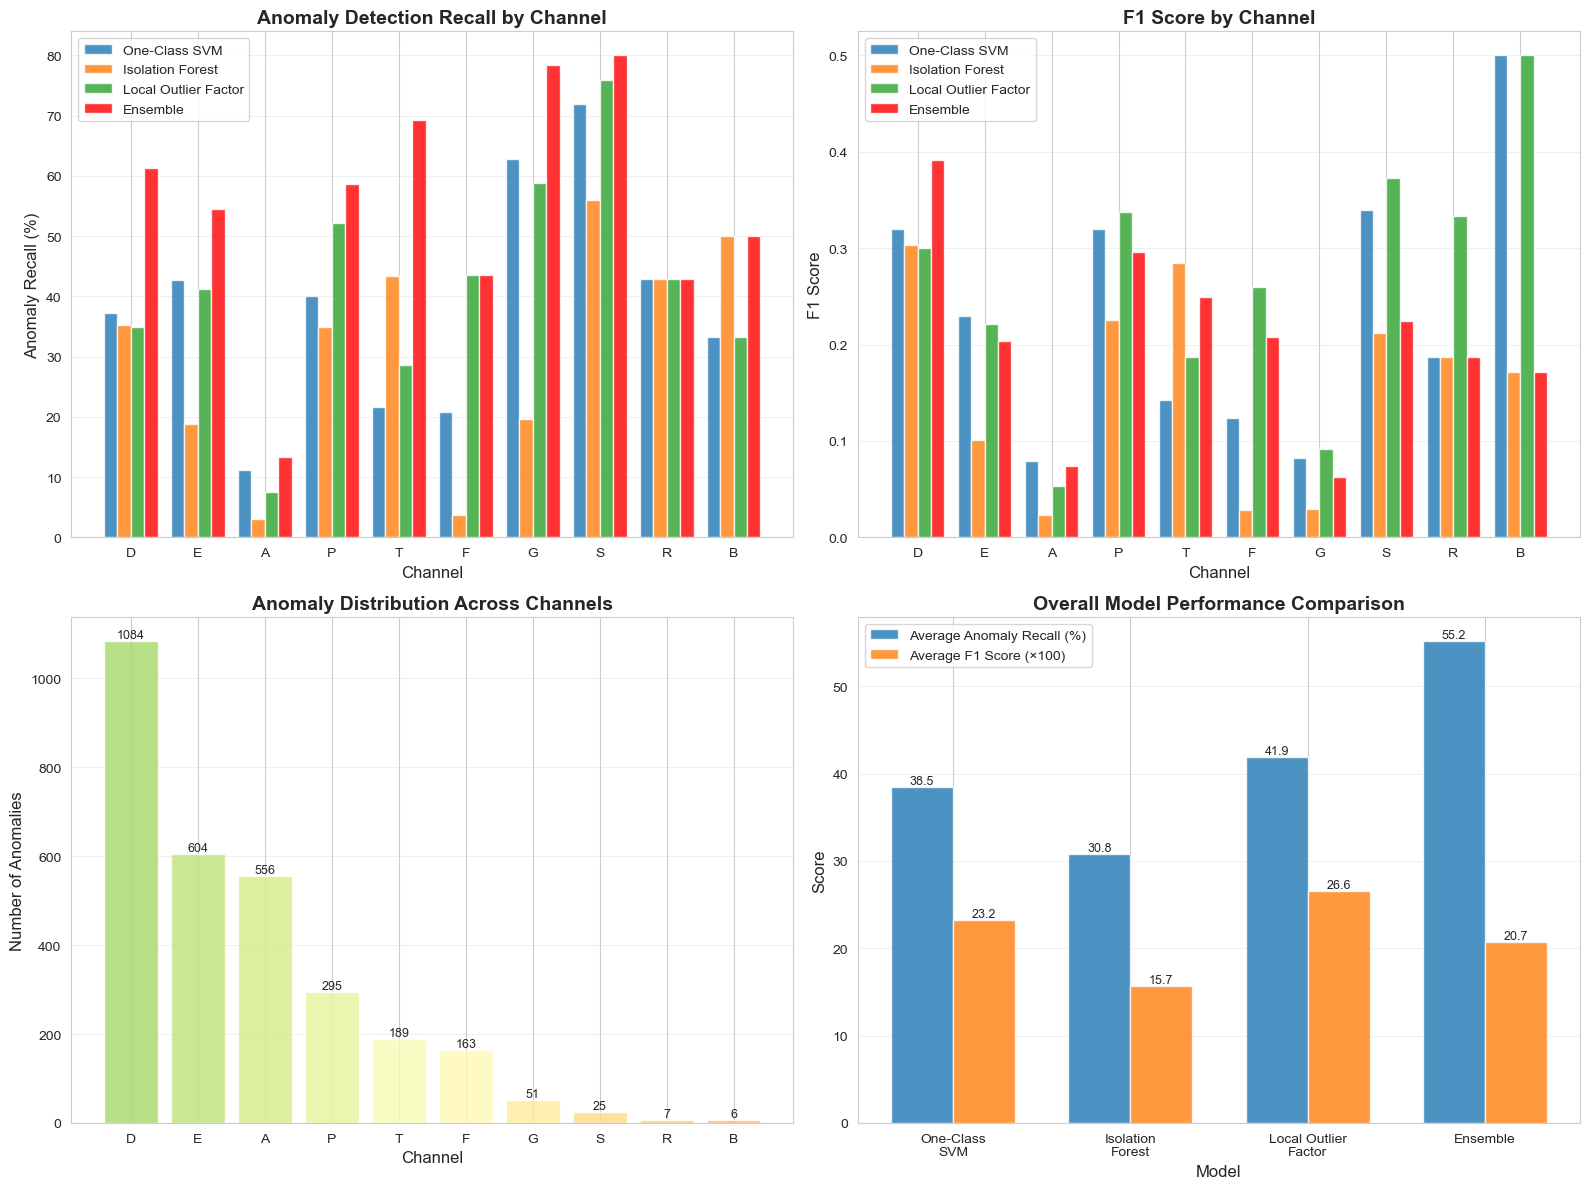

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

channel_names_list = list(standard_fitted_data.keys())
channels_sorted = sorted(channel_names_list, key=lambda x: svm_results[x]['n_anomalies'], reverse=True)
x = np.arange(len(channels_sorted))
width = 0.2

# 1. Anomaly recall by channel
ax1 = axes[0, 0]
svm_recalls = [svm_results[ch]['anomaly_recall'] * 100 for ch in channels_sorted]
if_recalls = [if_results[ch]['anomaly_recall'] * 100 for ch in channels_sorted]
lof_recalls = [lof_results[ch]['anomaly_recall'] * 100 for ch in channels_sorted]
ensemble_recalls = [ensemble_results[ch]['recall'] * 100 for ch in channels_sorted]

ax1.bar(x - 1.5*width, svm_recalls, width, label='One-Class SVM', alpha=0.8)
ax1.bar(x - 0.5*width, if_recalls, width, label='Isolation Forest', alpha=0.8)
ax1.bar(x + 0.5*width, lof_recalls, width, label='Local Outlier Factor', alpha=0.8)
ax1.bar(x + 1.5*width, ensemble_recalls, width, label='Ensemble', alpha=0.8, color='red')

ax1.set_xlabel('Channel', fontsize=12)
ax1.set_ylabel('Anomaly Recall (%)', fontsize=12)
ax1.set_title('Anomaly Detection Recall by Channel', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(channels_sorted)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. F1 score by channel
ax2 = axes[0, 1]
svm_f1s = [svm_results[ch]['f1'] for ch in channels_sorted]
if_f1s = [if_results[ch]['f1'] for ch in channels_sorted]
lof_f1s = [lof_results[ch]['f1'] for ch in channels_sorted]
ensemble_f1s = [ensemble_results[ch]['f1_score'] for ch in channels_sorted]

ax2.bar(x - 1.5*width, svm_f1s, width, label='One-Class SVM', alpha=0.8)
ax2.bar(x - 0.5*width, if_f1s, width, label='Isolation Forest', alpha=0.8)
ax2.bar(x + 0.5*width, lof_f1s, width, label='Local Outlier Factor', alpha=0.8)
ax2.bar(x + 1.5*width, ensemble_f1s, width, label='Ensemble', alpha=0.8, color='red')

ax2.set_xlabel('Channel', fontsize=12)
ax2.set_ylabel('F1 Score', fontsize=12)
ax2.set_title('F1 Score by Channel', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(channels_sorted)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Anomaly distribution
ax3 = axes[1, 0]
anomaly_counts = [svm_results[ch]['n_anomalies'] for ch in channels_sorted]
colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.7, len(channels_sorted)))

bars = ax3.bar(channels_sorted, anomaly_counts, color=colors, alpha=0.8)
ax3.set_xlabel('Channel', fontsize=12)
ax3.set_ylabel('Number of Anomalies', fontsize=12)
ax3.set_title('Anomaly Distribution Across Channels', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

for bar, count in zip(bars, anomaly_counts):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}',
            ha='center', va='bottom', fontsize=9)

# 4. Model performance summary
ax4 = axes[1, 1]
models = ['One-Class\nSVM', 'Isolation\nForest', 'Local Outlier\nFactor', 'Ensemble']
avg_recalls = [svm_avg_recall * 100, if_avg_recall * 100, lof_avg_recall * 100, ensemble_avg_recall * 100]
avg_f1s_scaled = [svm_avg_f1 * 100, if_avg_f1 * 100, lof_avg_f1 * 100, ensemble_avg_f1 * 100]

x_pos = np.arange(len(models))
width_summary = 0.35

bars1 = ax4.bar(x_pos - width_summary/2, avg_recalls, width_summary, label='Average Anomaly Recall (%)', alpha=0.8)
bars2 = ax4.bar(x_pos + width_summary/2, avg_f1s_scaled, width_summary, label='Average F1 Score (×100)', alpha=0.8)

ax4.set_xlabel('Model', fontsize=12)
ax4.set_ylabel('Score', fontsize=12)
ax4.set_title('Overall Model Performance Comparison', fontsize=14, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(models, fontsize=10)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('paper/template/figs/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()